# Household analysis on OpenSAFELY dummy data

Python code for pulling in the dummy data and running a household regression


In [1]:
# This cell loads the libraries used by the script

%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.optimize as op
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

# EDA

The next set of cells does exploratory data analysis / plots - we should discuss how to pull this kind of thing out


In [2]:
df = pd.read_csv('./hh_analysis_dataset_DRAFT.csv')

In [3]:
for c in df.columns:
    print(c)

patient_id
age
hh_id
hh_size
case
bmi_measured_date
hba1c_percentage_date
chronic_respiratory_disease_date
chronic_respiratory_disease
chronic_cardiac_disease_date
chronic_cardiac_disease
cancer_date
cancer
perm_immunodef_date
perm_immunodef
temp_immunodef_date
temp_immunodef
other_immuno
chronic_liver_disease_date
chronic_liver_disease
other_neuro_date
other_neuro
stroke_date
stroke
dementia_date
dementia
esrf_date
esrf
hypertension_date
hypertension
ra_sle_psoriasis_date
ra_sle_psoriasis
insulin_date
insulin
statin_date
statin
was_ventilated_flag
sex
rural_urban
region
ethnicity_16
gp_consult_count
bmi
hba1c_mmol_per_mol
hba1c_percentage
asthma_date
asthmacat
ace_inhibitors_date
ace_inhibitors
alpha_blockers_date
alpha_blockers
arbs_date
arbs
betablockers_date
betablockers
calcium_channel_blockers_date
calcium_channel_blockers
combination_bp_meds_date
combination_bp_meds
spironolactone_date
spironolactone
thiazide_diuretics_date
thiazide_diuretics
indexdate
eth5
eth16
stp
imd
agegrou

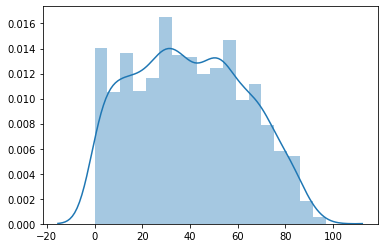

In [4]:
# Visualise the age distribution in the samples

sns.distplot(df.age1.values)

In [5]:
len(df)

2726

In [6]:
hhnums = pd.unique(df.hh_id)
nhh = len(hhnums)
print(nhh)

782


In [7]:
# Set up arrays for the size and number positive in each household

hhsizes = np.zeros(nhh)
hhpos = np.zeros(nhh)
hhneg = np.zeros(nhh)
hhmis = np.zeros(nhh)
for i, num in enumerate(hhnums):
    dfh = df[df.hh_id == num]
    hhsizes[i] = len(dfh)
    hhpos[i] = np.sum(dfh.case == 1)
    hhneg[i] = np.sum(dfh.case == 0)
    hhmis[i] = np.sum(pd.isna(dfh.case))

(array([ 50., 201., 222., 116.,  97.,  38.,  42.,   7.,   9.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 9 Patch objects>)

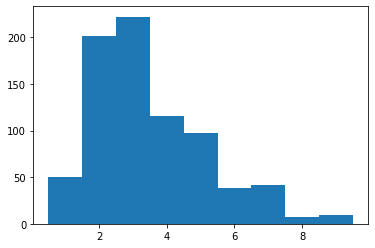

In [8]:
# Check the distribution of household sizes

plt.hist(hhsizes,0.5+np.arange(np.min(hhsizes)-1,np.max(hhsizes)+1))

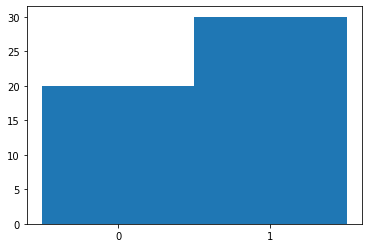

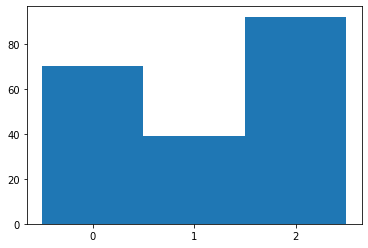

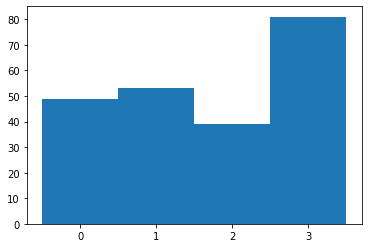

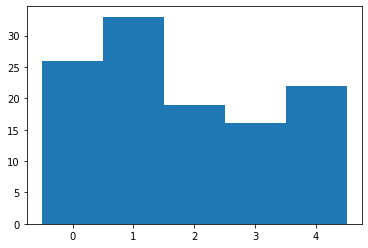

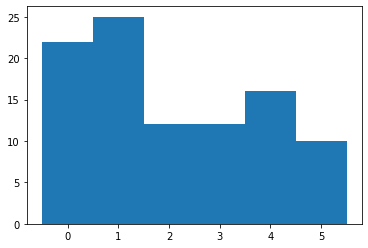

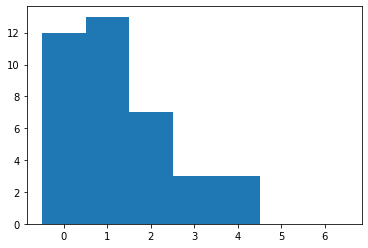

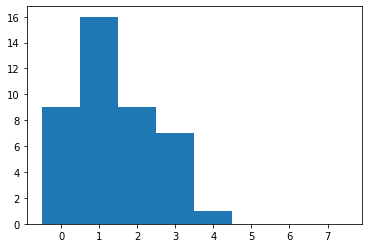

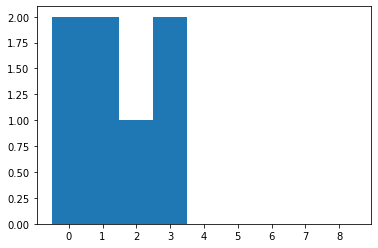

In [9]:
# Look at the distribution of cases in households by size

for nhsize in range(1,9):
    jj = np.where(hhsizes==nhsize)[0]
    plt.figure()
    plt.hist(hhpos[jj],np.arange(-0.5,nhsize+1.5,1.))
    plt.xticks(np.arange(0,nhsize+1,1))

# Data pre-processing

There are two major outputs for each household: a vector y of outcomes and a design matrix X. These are stored in arrays of length equal to the number of households Y and XX respectively.


In [10]:
# This is the number of age classes; here we will follow Roz's interests and consider two young ages

nages = 2

In [11]:
Y = [] # To store outcomes
XX = [] # To store design matrices
for i, num in enumerate(hhnums):
    dfh = df[df.hh_id == num]    
    
    mya = dfh.age1.values
    m = len(mya)
    myx = np.zeros((m,nages))
    myy = np.zeros(m)
    for j, a in enumerate(mya):
        if (a<=9):
            myx[j,:] = np.array([1, 0])
        elif ((a>9) and (a<=18)):
            myx[j,:] = np.array([0, 1])
        if (dfh.case.values[j] == 1):
            myy[j] = 1
    Y.append(myy)
    XX.append(np.atleast_2d(myx))

# Define functions

We need two functions:

* phi is the Laplace transform of the distribution of heterogeneity in transmissibility
* mynll is the negative log likelihood function for the model

Note that mynll here does not include a 'dilution' effect with number of household occupants (often called the 'Cauchemez model') and there are many other refinements we might like to consider.


In [12]:
def phi(s, logtheta=0.0):
    theta = np.exp(logtheta)
    return ((1.0 + theta*s)**(-1.0/theta))

In [13]:
def mynll(x):
    
    try: # Ideally catch the linear algebra fail directly
        llaL = x[0]
        llaG = x[1]
        logtheta = x[2]
        alpha = x[3:(3+nages)]
        beta = x[(3+nages):(3+2*nages)]
        gamma = x[(3+2*nages):]

        nlv = np.zeros(len(hhnums)) # Vector of negative log likelihoods
        for i in range(0,len(hhnums)):
            y = Y[i]
            X = XX[i]
            if np.all(y==0.0):
                nlv[i] = np.exp(llaG)*np.sum(np.exp(alpha@(X.T)))
            else:
                # Sort to go zeros then ones WLOG (could do in pre-processing)
                ii = np.argsort(y)
                y = y[ii]
                X = X[ii,:]
                q = sum(y>0)
                r = 2**q
                m = len(y)

                # Quantities that don't vary through the sum
                Bk = np.exp(-np.exp(llaG)*np.exp(alpha@(X.T)))
                laM = np.exp(llaL)*np.outer(np.exp(beta@(X.T)),np.exp(gamma@(X.T)))

                BB = np.zeros((r,r)) # To be the Ball matrix
                for jd in range(0,r):
                    for omd in range(0,jd+1):
                        jstr = format(jd,'0' + str(m) + 'b')
                        omstr = format(omd,'0' + str(m) + 'b')
                        j = np.array([int(jstr[x]) for x in range(0,len(jstr))])
                        om = np.array([int(omstr[x]) for x in range(0,len(omstr))])
                        BB[jd,omd] = 1.0/np.prod((phi((1-j)@laM,logtheta)**om)*(Bk**(1-j)))
                nlv[i] = -np.log(LA.solve(BB,np.ones(r))[-1])
        nll = np.sum(nlv)
        return nll
    except:
        nll = np.inf
        return nll

# Fit the model

The code here uses the simplest kind of maximum likelihood estimation that one might try - it is likely that there may need to be some tuning of this process to the data and computational resources available, and also that in the current context it will fail because almost by definition the model is mis-specified compared to the data.


In [14]:
# Starting parameters - and check that the target function evaluates OK at them

x0 = np.array([
    0.0,
    0.0,
    0.0,
    0.0, 0.0,
    0.0, 0.0,
    0.0, 0.0,
])
mynll(x0)

2327.834492518852

In [15]:
def callbackF(x):
    print('Evaluated at [{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}]: {:.8f}'.format(
        x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],mynll(x)))

In [20]:
# First try from (essentially) the origin using Nelder-Mead
# The exact optimisation method to use is expected to depend a lot on the actual data

fout = op.minimize(mynll,x0,method='Nelder-Mead',callback=callbackF,options={'maxiter' : 10000})
xhat = fout.x
fout

Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000]: 2327.20986728
Evaluated at [-0.000,-0.001,0.000,-0.000,0.000,0.000,0.000,0.000,0.000]: 2326.79714235
Evaluated at [-0.000,-0.001,0.000,-0.000,0.000,0.000,0.000,0.000,0.000]: 2326.79714235
Evaluated at [-0.000,-0.001,0.000,-0.000,0.000,0.000,0.000,0.000,0.000]: 2326.79714235
Evaluated at [-0.000,-0.001,0.000,-0.000,0.000,0.000,0.000,

Evaluated at [-0.077,-1.229,0.604,0.053,0.351,0.181,0.085,-0.103,0.308]: 1522.17340806
Evaluated at [-0.077,-1.229,0.604,0.053,0.351,0.181,0.085,-0.103,0.308]: 1522.17340806
Evaluated at [-0.077,-1.229,0.604,0.053,0.351,0.181,0.085,-0.103,0.308]: 1522.17340806
Evaluated at [-0.082,-1.311,0.644,0.057,0.376,0.193,0.091,-0.110,0.327]: 1513.74232660
Evaluated at [-0.083,-1.335,0.655,0.058,0.381,0.197,0.092,-0.112,0.334]: 1512.00342519
Evaluated at [-0.089,-1.419,0.697,0.061,0.407,0.209,0.097,-0.118,0.354]: 1507.78817020
Evaluated at [-0.089,-1.419,0.697,0.061,0.407,0.209,0.097,-0.118,0.354]: 1507.78817020
Evaluated at [-0.089,-1.419,0.697,0.061,0.407,0.209,0.097,-0.118,0.354]: 1507.78817020
Evaluated at [-0.089,-1.419,0.697,0.061,0.407,0.209,0.097,-0.118,0.354]: 1507.78817020
Evaluated at [-0.089,-1.419,0.697,0.061,0.407,0.209,0.097,-0.118,0.354]: 1507.78817020
Evaluated at [-0.089,-1.419,0.697,0.061,0.407,0.209,0.097,-0.118,0.354]: 1507.78817020
Evaluated at [-0.089,-1.419,0.697,0.061,0.4

Evaluated at [-0.093,-1.462,0.721,0.062,0.421,0.213,0.103,-0.121,0.362]: 1506.28001873
Evaluated at [-0.093,-1.462,0.721,0.062,0.421,0.213,0.103,-0.121,0.362]: 1506.28001873
Evaluated at [-0.095,-1.482,0.732,0.063,0.428,0.215,0.106,-0.122,0.365]: 1505.94008552
Evaluated at [-0.095,-1.482,0.732,0.063,0.428,0.215,0.106,-0.122,0.365]: 1505.94008552
Evaluated at [-0.095,-1.482,0.732,0.063,0.428,0.215,0.106,-0.122,0.365]: 1505.94008552
Evaluated at [-0.095,-1.482,0.732,0.063,0.428,0.215,0.106,-0.122,0.365]: 1505.94008552
Evaluated at [-0.095,-1.475,0.730,0.062,0.427,0.213,0.106,-0.121,0.362]: 1505.60620920
Evaluated at [-0.095,-1.475,0.730,0.062,0.427,0.213,0.106,-0.121,0.362]: 1505.60620920
Evaluated at [-0.095,-1.475,0.730,0.062,0.427,0.213,0.106,-0.121,0.362]: 1505.60620920
Evaluated at [-0.095,-1.459,0.725,0.061,0.424,0.209,0.107,-0.119,0.356]: 1505.14026574
Evaluated at [-0.095,-1.459,0.725,0.061,0.424,0.209,0.107,-0.119,0.356]: 1505.14026574
Evaluated at [-0.095,-1.459,0.725,0.061,0.4

Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.569,-1.506,1.905,-0.266,1.344,-0.719,1.070,0.320,-0.904]: 1381.49400759
Evaluated at [-0.567,

Evaluated at [-0.549,-1.477,1.846,-0.254,1.300,-0.688,1.032,0.305,-0.861]: 1380.94541584
Evaluated at [-0.549,-1.477,1.846,-0.254,1.300,-0.688,1.032,0.305,-0.861]: 1380.94541584
Evaluated at [-0.549,-1.477,1.846,-0.254,1.300,-0.688,1.032,0.305,-0.861]: 1380.94541584
Evaluated at [-0.549,-1.477,1.846,-0.254,1.300,-0.688,1.032,0.305,-0.861]: 1380.94541584
Evaluated at [-0.542,-1.471,1.828,-0.250,1.287,-0.677,1.019,0.300,-0.846]: 1380.92357686
Evaluated at [-0.554,-1.476,1.859,-0.258,1.310,-0.700,1.044,0.310,-0.877]: 1380.88476930
Evaluated at [-0.554,-1.476,1.859,-0.258,1.310,-0.700,1.044,0.310,-0.877]: 1380.88476930
Evaluated at [-0.554,-1.476,1.859,-0.258,1.310,-0.700,1.044,0.310,-0.877]: 1380.88476930
Evaluated at [-0.551,-1.481,1.854,-0.256,1.304,-0.693,1.038,0.307,-0.866]: 1380.82182221
Evaluated at [-0.551,-1.481,1.854,-0.256,1.304,-0.693,1.038,0.307,-0.866]: 1380.82182221
Evaluated at [-0.551,-1.481,1.854,-0.256,1.304,-0.693,1.038,0.307,-0.866]: 1380.82182221
Evaluated at [-0.552,

Evaluated at [-0.741,-1.613,2.501,-0.429,1.292,-1.399,1.725,0.433,-1.182]: 1356.75775951
Evaluated at [-0.797,-1.645,2.703,-0.486,1.255,-1.641,1.955,0.469,-1.267]: 1352.44273186
Evaluated at [-0.797,-1.645,2.703,-0.486,1.255,-1.641,1.955,0.469,-1.267]: 1352.44273186
Evaluated at [-0.797,-1.645,2.703,-0.486,1.255,-1.641,1.955,0.469,-1.267]: 1352.44273186
Evaluated at [-0.797,-1.645,2.703,-0.486,1.255,-1.641,1.955,0.469,-1.267]: 1352.44273186
Evaluated at [-0.797,-1.645,2.703,-0.486,1.255,-1.641,1.955,0.469,-1.267]: 1352.44273186
Evaluated at [-0.797,-1.645,2.703,-0.486,1.255,-1.641,1.955,0.469,-1.267]: 1352.44273186
Evaluated at [-0.797,-1.645,2.703,-0.486,1.255,-1.641,1.955,0.469,-1.267]: 1352.44273186
Evaluated at [-0.802,-1.542,2.666,-0.493,1.282,-1.644,1.943,0.491,-1.335]: 1346.18256974
Evaluated at [-0.802,-1.542,2.666,-0.493,1.282,-1.644,1.943,0.491,-1.335]: 1346.18256974
Evaluated at [-0.802,-1.542,2.666,-0.493,1.282,-1.644,1.943,0.491,-1.335]: 1346.18256974
Evaluated at [-0.855,

Evaluated at [-1.134,-1.132,3.954,-0.995,0.058,-4.051,4.027,0.711,-1.765]: 1273.58704246
Evaluated at [-1.134,-1.132,3.954,-0.995,0.058,-4.051,4.027,0.711,-1.765]: 1273.58704246
Evaluated at [-1.136,-1.132,3.961,-0.997,0.057,-4.060,4.035,0.713,-1.769]: 1273.58552722
Evaluated at [-1.136,-1.132,3.961,-0.997,0.057,-4.060,4.035,0.713,-1.769]: 1273.58552722
Evaluated at [-1.136,-1.132,3.961,-0.997,0.057,-4.060,4.035,0.713,-1.769]: 1273.58552722
Evaluated at [-1.136,-1.132,3.961,-0.997,0.057,-4.060,4.035,0.713,-1.769]: 1273.58552722
Evaluated at [-1.136,-1.132,3.961,-0.997,0.057,-4.060,4.035,0.713,-1.769]: 1273.58552722
Evaluated at [-1.141,-1.129,3.978,-1.003,0.048,-4.087,4.059,0.717,-1.777]: 1273.58462799
Evaluated at [-1.141,-1.130,3.980,-1.003,0.052,-4.086,4.059,0.717,-1.779]: 1273.58430732
Evaluated at [-1.141,-1.130,3.980,-1.003,0.052,-4.086,4.059,0.717,-1.779]: 1273.58430732
Evaluated at [-1.141,-1.130,3.980,-1.003,0.052,-4.086,4.059,0.717,-1.779]: 1273.58430732
Evaluated at [-1.139,

Evaluated at [-1.139,-1.130,3.972,-1.001,0.054,-4.077,4.050,0.716,-1.776]: 1273.58358907
Evaluated at [-1.139,-1.130,3.972,-1.001,0.054,-4.077,4.050,0.716,-1.776]: 1273.58358907
Evaluated at [-1.139,-1.130,3.972,-1.001,0.054,-4.077,4.050,0.716,-1.776]: 1273.58358907
Evaluated at [-1.140,-1.130,3.973,-1.001,0.054,-4.078,4.051,0.716,-1.776]: 1273.58358008
Evaluated at [-1.140,-1.130,3.973,-1.001,0.054,-4.078,4.051,0.716,-1.776]: 1273.58358008
Evaluated at [-1.140,-1.130,3.973,-1.001,0.054,-4.078,4.051,0.716,-1.776]: 1273.58358008
Evaluated at [-1.140,-1.130,3.973,-1.001,0.054,-4.078,4.051,0.716,-1.776]: 1273.58358008
Evaluated at [-1.140,-1.130,3.973,-1.001,0.054,-4.078,4.051,0.716,-1.776]: 1273.58358008
Evaluated at [-1.139,-1.130,3.972,-1.001,0.054,-4.076,4.050,0.716,-1.776]: 1273.58357225
Evaluated at [-1.139,-1.130,3.973,-1.001,0.054,-4.077,4.051,0.716,-1.776]: 1273.58355800
Evaluated at [-1.139,-1.130,3.973,-1.001,0.054,-4.077,4.051,0.716,-1.776]: 1273.58355800
Evaluated at [-1.139,

Evaluated at [-1.146,-1.132,3.988,-1.005,0.067,-4.083,4.055,0.723,-1.789]: 1273.57418862
Evaluated at [-1.146,-1.132,3.988,-1.005,0.067,-4.083,4.055,0.723,-1.789]: 1273.57418862
Evaluated at [-1.146,-1.132,3.988,-1.005,0.067,-4.083,4.055,0.723,-1.789]: 1273.57418862
Evaluated at [-1.146,-1.132,3.988,-1.005,0.067,-4.083,4.055,0.723,-1.789]: 1273.57418862
Evaluated at [-1.146,-1.132,3.988,-1.005,0.067,-4.083,4.055,0.723,-1.789]: 1273.57418862
Evaluated at [-1.146,-1.132,3.988,-1.005,0.067,-4.083,4.055,0.723,-1.789]: 1273.57418862
Evaluated at [-1.148,-1.134,3.990,-1.005,0.073,-4.079,4.051,0.725,-1.792]: 1273.57281420
Evaluated at [-1.148,-1.132,3.992,-1.006,0.069,-4.085,4.056,0.725,-1.792]: 1273.57060581
Evaluated at [-1.148,-1.132,3.992,-1.006,0.069,-4.085,4.056,0.725,-1.792]: 1273.57060581
Evaluated at [-1.148,-1.132,3.992,-1.006,0.069,-4.085,4.056,0.725,-1.792]: 1273.57060581
Evaluated at [-1.148,-1.132,3.992,-1.006,0.069,-4.085,4.056,0.725,-1.792]: 1273.57060581
Evaluated at [-1.148,

Evaluated at [-1.221,-1.121,4.089,-1.029,0.125,-4.015,3.880,0.827,-1.800]: 1273.26020231
Evaluated at [-1.221,-1.121,4.089,-1.029,0.125,-4.015,3.880,0.827,-1.800]: 1273.26020231
Evaluated at [-1.228,-1.121,4.097,-1.031,0.125,-4.003,3.855,0.837,-1.794]: 1273.20428522
Evaluated at [-1.228,-1.121,4.097,-1.031,0.125,-4.003,3.855,0.837,-1.794]: 1273.20428522
Evaluated at [-1.228,-1.121,4.097,-1.031,0.125,-4.003,3.855,0.837,-1.794]: 1273.20428522
Evaluated at [-1.228,-1.121,4.097,-1.031,0.125,-4.003,3.855,0.837,-1.794]: 1273.20428522
Evaluated at [-1.252,-1.124,4.129,-1.037,0.147,-3.971,3.788,0.871,-1.791]: 1273.15037628
Evaluated at [-1.252,-1.124,4.129,-1.037,0.147,-3.971,3.788,0.871,-1.791]: 1273.15037628
Evaluated at [-1.252,-1.124,4.129,-1.037,0.147,-3.971,3.788,0.871,-1.791]: 1273.15037628
Evaluated at [-1.252,-1.124,4.129,-1.037,0.147,-3.971,3.788,0.871,-1.791]: 1273.15037628
Evaluated at [-1.245,-1.126,4.095,-1.025,0.144,-3.909,3.716,0.870,-1.754]: 1272.97200035
Evaluated at [-1.245,

Evaluated at [-2.526,-1.127,3.897,-0.689,0.080,2.852,-7.091,3.391,2.164]: 1259.71173856
Evaluated at [-2.526,-1.127,3.897,-0.689,0.080,2.852,-7.091,3.391,2.164]: 1259.71173856
Evaluated at [-2.526,-1.127,3.897,-0.689,0.080,2.852,-7.091,3.391,2.164]: 1259.71173856
Evaluated at [-2.526,-1.127,3.897,-0.689,0.080,2.852,-7.091,3.391,2.164]: 1259.71173856
Evaluated at [-2.526,-1.127,3.897,-0.689,0.080,2.852,-7.091,3.391,2.164]: 1259.71173856
Evaluated at [-2.824,-1.145,3.835,-0.600,0.106,4.495,-9.675,3.983,3.087]: 1259.57865390
Evaluated at [-2.836,-1.106,3.989,-0.664,0.027,4.080,-9.187,3.952,2.909]: 1259.33230622
Evaluated at [-3.453,-1.096,4.059,-0.565,0.019,6.870,-13.766,5.107,4.511]: 1258.90659644
Evaluated at [-3.453,-1.096,4.059,-0.565,0.019,6.870,-13.766,5.107,4.511]: 1258.90659644
Evaluated at [-3.633,-1.073,4.258,-0.607,0.124,7.160,-14.366,5.374,4.586]: 1257.58672705
Evaluated at [-3.633,-1.073,4.258,-0.607,0.124,7.160,-14.366,5.374,4.586]: 1257.58672705
Evaluated at [-3.633,-1.073,

Evaluated at [-15.305,-1.179,9.101,0.017,0.188,50.547,-88.415,25.915,29.607]: 1237.85373266
Evaluated at [-15.305,-1.179,9.101,0.017,0.188,50.547,-88.415,25.915,29.607]: 1237.85373266
Evaluated at [-15.305,-1.179,9.101,0.017,0.188,50.547,-88.415,25.915,29.607]: 1237.85373266
Evaluated at [-16.785,-1.198,9.968,0.003,0.171,55.357,-96.898,28.428,32.418]: 1237.75959088
Evaluated at [-16.785,-1.198,9.968,0.003,0.171,55.357,-96.898,28.428,32.418]: 1237.75959088
Evaluated at [-16.785,-1.198,9.968,0.003,0.171,55.357,-96.898,28.428,32.418]: 1237.75959088
Evaluated at [-16.785,-1.198,9.968,0.003,0.171,55.357,-96.898,28.428,32.418]: 1237.75959088
Evaluated at [-16.785,-1.198,9.968,0.003,0.171,55.357,-96.898,28.428,32.418]: 1237.75959088
Evaluated at [-16.785,-1.198,9.968,0.003,0.171,55.357,-96.898,28.428,32.418]: 1237.75959088
Evaluated at [-16.785,-1.198,9.968,0.003,0.171,55.357,-96.898,28.428,32.418]: 1237.75959088
Evaluated at [-16.559,-1.191,9.771,0.028,0.198,54.793,-95.818,28.066,32.061]: 12

Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.668,-1.189,16.471,0.029,0.183,95.041,-166.394,48.770,55.385]: 1237.58967639
Evaluated at [-28.574,-1.190,16.410,0.033,0.182,94.758,-165.887,48.614,55.222]: 1237.58964274
Evaluated at [-28.574,-1.190,16.410,0.033,0.182,94.758,-165.

Evaluated at [-33.447,-1.190,19.112,0.031,0.183,110.938,-194.262,56.943,64.593]: 1237.58929641
Evaluated at [-34.082,-1.190,19.463,0.031,0.183,113.050,-197.966,58.030,65.817]: 1237.58929090
Evaluated at [-34.082,-1.190,19.463,0.031,0.183,113.050,-197.966,58.030,65.817]: 1237.58929090
Evaluated at [-34.082,-1.190,19.463,0.031,0.183,113.050,-197.966,58.030,65.817]: 1237.58929090
Evaluated at [-34.153,-1.190,19.502,0.031,0.183,113.286,-198.379,58.151,65.954]: 1237.58929009
Evaluated at [-34.153,-1.190,19.502,0.031,0.183,113.286,-198.379,58.151,65.954]: 1237.58929009
Evaluated at [-34.153,-1.190,19.502,0.031,0.183,113.286,-198.379,58.151,65.954]: 1237.58929009
Evaluated at [-34.153,-1.190,19.502,0.031,0.183,113.286,-198.379,58.151,65.954]: 1237.58929009
Evaluated at [-34.153,-1.190,19.502,0.031,0.183,113.286,-198.379,58.151,65.954]: 1237.58929009
Evaluated at [-34.153,-1.190,19.502,0.031,0.183,113.286,-198.379,58.151,65.954]: 1237.58929009
Evaluated at [-34.990,-1.189,19.966,0.031,0.182,11

Evaluated at [-40.915,-1.190,23.244,0.031,0.183,135.758,-237.781,69.711,78.970]: 1237.58927249
Evaluated at [-40.915,-1.190,23.244,0.031,0.183,135.758,-237.781,69.711,78.970]: 1237.58927249
Evaluated at [-40.915,-1.190,23.244,0.031,0.183,135.758,-237.781,69.711,78.970]: 1237.58927249
Evaluated at [-41.972,-1.190,23.830,0.031,0.183,139.272,-243.942,71.519,81.005]: 1237.58927236
Evaluated at [-41.972,-1.190,23.830,0.031,0.183,139.272,-243.942,71.519,81.005]: 1237.58927236
Evaluated at [-41.972,-1.190,23.830,0.031,0.183,139.272,-243.942,71.519,81.005]: 1237.58927236
Evaluated at [-42.743,-1.190,24.257,0.031,0.183,141.834,-248.435,72.837,82.490]: 1237.58927226
Evaluated at [-42.743,-1.190,24.257,0.031,0.183,141.834,-248.435,72.837,82.490]: 1237.58927226
Evaluated at [-42.743,-1.190,24.257,0.031,0.183,141.834,-248.435,72.837,82.490]: 1237.58927226
Evaluated at [-42.743,-1.190,24.257,0.031,0.183,141.834,-248.435,72.837,82.490]: 1237.58927226
Evaluated at [-43.536,-1.190,24.695,0.031,0.183,14

Evaluated at [-49.679,-1.190,28.096,0.031,0.183,164.886,-288.853,84.696,95.842]: 1237.58927195
Evaluated at [-49.679,-1.190,28.096,0.031,0.183,164.886,-288.853,84.696,95.842]: 1237.58927195
Evaluated at [-49.829,-1.190,28.178,0.031,0.183,165.382,-289.724,84.951,96.129]: 1237.58927195
Evaluated at [-50.482,-1.190,28.540,0.031,0.183,167.554,-293.532,86.068,97.387]: 1237.58927195
Evaluated at [-50.782,-1.190,28.706,0.031,0.183,168.551,-295.280,86.581,97.965]: 1237.58927195
Evaluated at [-50.782,-1.190,28.706,0.031,0.183,168.551,-295.280,86.581,97.965]: 1237.58927195
Evaluated at [-50.782,-1.190,28.706,0.031,0.183,168.551,-295.280,86.581,97.965]: 1237.58927195
Evaluated at [-50.782,-1.190,28.706,0.031,0.183,168.551,-295.280,86.581,97.965]: 1237.58927195
Evaluated at [-50.782,-1.190,28.706,0.031,0.183,168.551,-295.280,86.581,97.965]: 1237.58927195
Evaluated at [-50.782,-1.190,28.706,0.031,0.183,168.551,-295.280,86.581,97.965]: 1237.58927195
Evaluated at [-50.782,-1.190,28.706,0.031,0.183,16

Evaluated at [-59.156,-1.190,33.341,0.031,0.183,196.381,-344.078,100.899,114.085]: 1237.58927195
Evaluated at [-59.156,-1.190,33.341,0.031,0.183,196.381,-344.078,100.899,114.085]: 1237.58927195
Evaluated at [-60.001,-1.190,33.809,0.031,0.183,199.191,-349.004,102.344,115.712]: 1237.58927195
Evaluated at [-60.001,-1.190,33.809,0.031,0.183,199.191,-349.004,102.344,115.712]: 1237.58927195
Evaluated at [-60.001,-1.190,33.809,0.031,0.183,199.191,-349.004,102.344,115.712]: 1237.58927195
Evaluated at [-60.001,-1.190,33.809,0.031,0.183,199.191,-349.004,102.344,115.712]: 1237.58927195
Evaluated at [-60.375,-1.190,34.016,0.031,0.183,200.434,-351.183,102.983,116.432]: 1237.58927195
Evaluated at [-60.375,-1.190,34.016,0.031,0.183,200.434,-351.183,102.983,116.432]: 1237.58927195
Evaluated at [-60.840,-1.190,34.273,0.031,0.183,201.979,-353.893,103.778,117.327]: 1237.58927195
Evaluated at [-60.840,-1.190,34.273,0.031,0.183,201.979,-353.893,103.778,117.327]: 1237.58927195
Evaluated at [-60.840,-1.190,3

Evaluated at [-65.047,-1.190,36.602,0.031,0.183,215.960,-378.407,110.971,125.425]: 1237.58927195
Evaluated at [-65.047,-1.190,36.602,0.031,0.183,215.960,-378.407,110.971,125.425]: 1237.58927195
Evaluated at [-65.047,-1.190,36.602,0.031,0.183,215.960,-378.407,110.971,125.425]: 1237.58927195
Evaluated at [-65.754,-1.190,36.993,0.031,0.183,218.311,-382.529,112.180,126.787]: 1237.58927195
Evaluated at [-65.754,-1.190,36.993,0.031,0.183,218.311,-382.529,112.180,126.787]: 1237.58927195
Evaluated at [-65.754,-1.190,36.993,0.031,0.183,218.311,-382.529,112.180,126.787]: 1237.58927195
Evaluated at [-65.754,-1.190,36.993,0.031,0.183,218.311,-382.529,112.180,126.787]: 1237.58927195
Evaluated at [-65.754,-1.190,36.993,0.031,0.183,218.311,-382.529,112.180,126.787]: 1237.58927195
Evaluated at [-65.754,-1.190,36.993,0.031,0.183,218.311,-382.529,112.180,126.787]: 1237.58927195
Evaluated at [-65.754,-1.190,36.993,0.031,0.183,218.311,-382.529,112.180,126.787]: 1237.58927195
Evaluated at [-65.754,-1.190,3

 final_simplex: (array([[-6.57544189e+01, -1.18959091e+00,  3.69930022e+01,
         3.08221987e-02,  1.82644976e-01,  2.18310754e+02,
        -3.82528664e+02,  1.12180023e+02,  1.26786865e+02],
       [-6.57544027e+01, -1.18959091e+00,  3.69929932e+01,
         3.08221987e-02,  1.82644976e-01,  2.18310700e+02,
        -3.82528569e+02,  1.12179996e+02,  1.26786834e+02],
       [-6.57544169e+01, -1.18959091e+00,  3.69930011e+01,
         3.08221987e-02,  1.82644976e-01,  2.18310747e+02,
        -3.82528652e+02,  1.12180020e+02,  1.26786861e+02],
       [-6.57544270e+01, -1.18959091e+00,  3.69930067e+01,
         3.08221987e-02,  1.82644976e-01,  2.18310780e+02,
        -3.82528710e+02,  1.12180037e+02,  1.26786880e+02],
       [-6.57544063e+01, -1.18959091e+00,  3.69929952e+01,
         3.08221987e-02,  1.82644976e-01,  2.18310712e+02,
        -3.82528590e+02,  1.12180002e+02,  1.26786840e+02],
       [-6.57544022e+01, -1.18959091e+00,  3.69929930e+01,
         3.08221987e-02,  1.826449

In [23]:
pn = len(x0)
delta = 1e-2 # This finite difference needs some unavoidable tuning by hand
dx = delta*xhat
ej = np.zeros(pn)
ek = np.zeros(pn)
Hinv = np.zeros((pn,pn))
for j in tqdm(range(0,pn)):
    ej[j] = dx[j]
    for k in range(0,j):
        ek[k] = dx[k]
        Hinv[j,k] = mynll(xhat+ej+ek) - mynll(xhat+ej-ek) - mynll(xhat-ej+ek) + mynll(xhat-ej-ek)
        ek[k] = 0.
    Hinv[j,j] = - mynll(xhat+2*ej) + 16*mynll(xhat+ej) - 30*mynll(xhat) + 16*mynll(xhat-ej) - mynll(xhat-2*ej)
    ej[j] = 0.
Hinv += np.triu(Hinv.T,1)
Hinv /= (4.*np.outer(dx,dx) + np.diag(8.*dx**2)) # TO DO: replace with a chol ...
covmat = LA.inv(0.5*(Hinv+Hinv.T))
stds = np.sqrt(np.diag(covmat))
stds

/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


array([           nan, 4.81873501e-02, 5.48573078e+05, 1.32659095e-01,
       1.28701139e-01, 4.57830834e+06,            nan,            nan,
                  nan])

In [24]:
print('Baseline probability of infection from outside is {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*(1.-np.exp(-np.exp(xhat[1]))),
    100.*(1.-np.exp(-np.exp(xhat[1]-1.96*stds[1]))),
    100.*(1.-np.exp(-np.exp(xhat[1]+1.96*stds[1]))),
    ))

# phi gets bigger as xhat[1] gets smaller and bigger as xhat[2] gets bigger
# 'Safest' method is Monte Carlo - sample 
mymu = xhat[[0,2]]
mySig = covmat[[0,2],:][:,[0,2]]
m = 4000
sarvec = np.zeros(m)
for i in range(0,m):
    uu = np.random.multivariate_normal(mymu,mySig)
    sarvec[i] = 100.*(1.-phi(np.exp(uu[0]),uu[1]))
    
print('Baseline SAR is {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*(1.-phi(np.exp(xhat[0]),xhat[2])),
    np.percentile(sarvec,2.5),
    np.percentile(sarvec,97.5),
    ))

print('Relative external exposure for <=9yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[3]),
    100.*np.exp(xhat[3]-1.96*stds[3]),
    100.*np.exp(xhat[3]+1.96*stds[3]),
    ))
print('Relative external exposure for 10-18yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[4]),
    100.*np.exp(xhat[4]-1.96*stds[4]),
    100.*np.exp(xhat[4]+1.96*stds[4]),
    ))

print('Relative susceptibility for <=9yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[5]),
    100.*np.exp(xhat[5]-1.96*stds[5]),
    100.*np.exp(xhat[5]+1.96*stds[5]),
    ))
print('Relative susceptibility for 10-18yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[6]),
    100.*np.exp(xhat[6]-1.96*stds[6]),
    100.*np.exp(xhat[6]+1.96*stds[6]),
    ))

print('Relative transmissibility for <=9yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[7]),
    100.*np.exp(xhat[7]-1.96*stds[7]),
    100.*np.exp(xhat[7]+1.96*stds[7]),
    ))
print('Relative transmissibility for 10-18yo {:.1f} ({:.1f},{:.1f}) %'.format(
    100.*np.exp(xhat[8]),
    100.*np.exp(xhat[8]-1.96*stds[8]),
    100.*np.exp(xhat[8]+1.96*stds[8]),
    ))


Baseline probability of infection from outside is 26.2 (24.2,28.4) %


/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  
/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Baseline SAR is 0.0 (nan,nan) %
Relative external exposure for <=9yo 103.1 (79.5,133.8) %
Relative external exposure for 10-18yo 120.0 (93.3,154.5) %
Relative susceptibility for <=9yo 6473745680521278870101517409490556427432005355849479658811821610514461282919161647515900567355392.0 (0.0,inf) %
Relative susceptibility for 10-18yo 0.0 (nan,nan) %
Relative transmissibility for <=9yo 523799530438513999240421668946643127191119637512192.0 (nan,nan) %
Relative transmissibility for 10-18yo 1155675035405068003189539162429240125574523855850082140160.0 (nan,nan) %


/Users/thomas/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
